<a href="https://colab.research.google.com/github/christophersingh/Master/blob/main/Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**See Links**

https://github.com/adib0073/Time_Series_Anomaly_Detection/blob/master/Time%20Series%20Anomaly%20Detection.ipynb

https://towardsdatascience.com/effective-approaches-for-time-series-anomaly-detection-9485b40077f1

https://aditya-bhattacharya.net/2020/07/20/sales-and-demand-forecast-analysis/3/



In [73]:
import numpy as np
import pandas as pd

df = pd.read_csv('https://github.com/DataForScience/Timeseries/blob/master/data/international-airline-passengers.csv?raw=true', sep=';')
"""df['date'] = df['Unnamed: 0'].apply(lambda x: x.strip())
df['date'] = df['date'].apply(lambda x: x.replace(' ', '-').lower())
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.rename({'Imports of all grades of crude oil from World to Total U.S. (US), Monthly (thousand barrels)': 'Temp'}, axis=1, inplace=True)
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m')
df.set_index('date',inplace=True)
df.index = pd.to_datetime(df.index)"""
df['Normalized Profit'] = df['Passengers']
df['Time Period'] = pd.to_datetime(df['Month']).dt.strftime('%Y-%m')
df.set_index('Time Period',inplace=True)
df.index = pd.to_datetime(df.index)
df.drop(['Month', 'Passengers'], axis=1, inplace=True)
df

,Normalized Profit
Time Period,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Normalized Profit  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


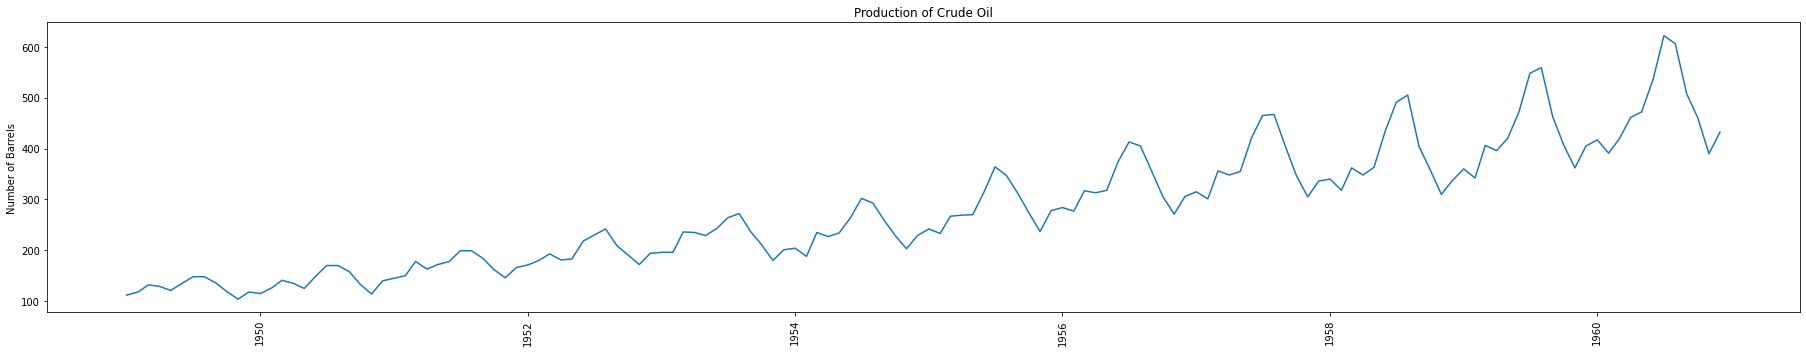

In [75]:
from matplotlib import pyplot as plt

plt.figure(figsize=(25,5))
plt.plot(df.index, df['Normalized Profit'])
plt.title('Production of Crude Oil')
plt.xticks(rotation=90)
plt.tight_layout()
plt.ylabel('Number of Barrels');
plt.show()

In [76]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns
"""!pip install -q pmdarima
import pmdarima as pm
from pmdarima.model_selection import train_test_split"""
warnings.filterwarnings("ignore")

In [77]:
ts_dataframe = df
ts_dataframe.head()

,Normalized Profit
Time Period,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [78]:
import math
# Change - added Coalesce method to replace null value with zero
def coalesce(value):
    if math.isnan(value):
        return 0.0
    else:
        return value
    

def generate_statistical_profile(series):
    grouped_series = series.groupby(['Time Period'])['Normalized Profit'].sum().reset_index()
    grouped_series['Time Period'] = pd.to_datetime(grouped_series['Time Period'], errors='coerce')
    grouped_series['mm-yy'] =  grouped_series['Time Period'].dt.month * 10**4 + grouped_series['Time Period'].dt.year
    grouped_series['qq-yy'] =  grouped_series['Time Period'].dt.quarter * 10**4 + grouped_series['Time Period'].dt.year
    grouped_series['yy'] =  grouped_series['Time Period'].dt.year

    new_profile_m = pd.DataFrame()

    new_profile_m['max_monthly_qty'] = grouped_series.groupby(['mm-yy'])['Normalized Profit'].max().values
    new_profile_m['min_monthly_qty'] = grouped_series.groupby(['mm-yy'])['Normalized Profit'].min().values    
    new_profile_m['moving_avg_max'] = new_profile_m['max_monthly_qty'].rolling(2, min_periods=1).mean()
    new_profile_m['moving_avg_min'] = new_profile_m['min_monthly_qty'].rolling(2, min_periods=1).mean()

    new_profile_m['total_monthly_qty'] = grouped_series.groupby(['mm-yy'])['Normalized Profit'].sum().values
    new_profile_m['monthly_freq'] = grouped_series.groupby(['mm-yy'])['Normalized Profit'].count().values
    new_profile_m['moving_avg_total_m'] = new_profile_m['total_monthly_qty'].rolling(2, min_periods=1).mean()
    new_profile_m['moving_avg_freq_m'] = new_profile_m['monthly_freq'].rolling(2, min_periods=1).mean()

    new_profile_q = pd.DataFrame()
    new_profile_q['total_quarterly_qty'] = grouped_series.groupby(['qq-yy'])['Normalized Profit'].sum().values
    new_profile_q['quarterly_freq'] = grouped_series.groupby(['qq-yy'])['Normalized Profit'].count().values
    new_profile_q['moving_avg_total_q'] = new_profile_q['total_quarterly_qty'].rolling(2, min_periods=1).mean()
    new_profile_q['moving_avg_freq_q'] = new_profile_q['quarterly_freq'].rolling(2, min_periods=1).mean()

    new_profile_y = pd.DataFrame()
    new_profile_y['total_yearly_qty'] = grouped_series.groupby(['yy'])['Normalized Profit'].sum().values
    new_profile_y['yearly_freq'] = grouped_series.groupby(['yy'])['Normalized Profit'].count().values
    new_profile_y['moving_avg_total_y'] = new_profile_y['total_yearly_qty'].rolling(2, min_periods=1).mean()
    new_profile_y['moving_avg_freq_y'] = new_profile_y['yearly_freq'].rolling(2, min_periods=1).mean()

    
    statiscal_profile = [
        new_profile_m['max_monthly_qty'].median(),
        new_profile_m['moving_avg_max'].mean(),
        new_profile_m['moving_avg_max'].mean() + 0.5 * coalesce(new_profile_m['moving_avg_max'].std()),
        
        new_profile_m['min_monthly_qty'].median(),
        new_profile_m['moving_avg_min'].mean(),
        new_profile_m['moving_avg_min'].mean() - 0.5 * coalesce(new_profile_m['moving_avg_min'].std()),
        
        new_profile_m['moving_avg_total_m'].mean() + 0.5 * coalesce(new_profile_m['moving_avg_total_m'].std()),
        new_profile_m['moving_avg_freq_m'].mean() + 0.5 * coalesce(new_profile_m['moving_avg_freq_m'].std()),
        
        new_profile_m['moving_avg_total_m'].mean() - 0.5 * coalesce(new_profile_m['moving_avg_total_m'].std()),
        new_profile_m['moving_avg_freq_m'].mean() - 0.5 * coalesce(new_profile_m['moving_avg_freq_m'].std()),
        
        new_profile_q['moving_avg_total_q'].mean() + 0.5 * coalesce(new_profile_q['moving_avg_total_q'].std()),
        new_profile_q['moving_avg_freq_q'].mean() + 0.5 * coalesce(new_profile_q['moving_avg_freq_q'].std()),
        
        new_profile_q['moving_avg_total_q'].mean() - 0.5 * coalesce(new_profile_q['moving_avg_total_q'].std()),
        new_profile_q['moving_avg_freq_q'].mean() - 0.5 * coalesce(new_profile_q['moving_avg_freq_q'].std()),
        
        new_profile_y['moving_avg_total_y'].mean() + 0.5 * coalesce(new_profile_y['moving_avg_total_y'].std()),
        new_profile_y['moving_avg_freq_y'].mean() + 0.5 * coalesce(new_profile_y['moving_avg_freq_y'].std()),
        
        new_profile_y['moving_avg_total_y'].mean() - 0.5 * coalesce(new_profile_y['moving_avg_total_y'].std()),
        new_profile_y['moving_avg_freq_y'].mean() - 0.5 * coalesce(new_profile_y['moving_avg_freq_y'].std()),
    ]
    
    statiscal_profile = [round(e,2) for e in statiscal_profile]
    
    return statiscal_profile

In [79]:
def format_statistical_profile(profile_value):
    individual_profile = {}
    individual_profile["UpperThreshold"] = max(profile_value[0], profile_value[1], profile_value[2])
    individual_profile["LowerThreshold"] = min(profile_value[4], profile_value[5], profile_value[6])
    individual_profile["UTotalMonth"] = profile_value[6]
    individual_profile["UFreqMonth"] = profile_value[7]
    individual_profile["LTotalMonth"] = profile_value[8]
    individual_profile["LFreqMonth"] = profile_value[9]    
    individual_profile["UTotalQuarter"] = profile_value[10]
    individual_profile["UFreqQuarter"] = profile_value[11]
    individual_profile["LTotalQuarter"] = profile_value[12]
    individual_profile["LFreqQuarter"] = profile_value[13]     
    individual_profile["UTotalYear"] = profile_value[14]
    individual_profile["UFreqYear"] = profile_value[15]
    individual_profile["LTotalYear"] = profile_value[16]
    individual_profile["LFreqYear"] = profile_value[17]
    
    return individual_profile

In [80]:
profile_value = generate_statistical_profile(ts_dataframe.reset_index())
statistical_profile = format_statistical_profile(profile_value)

In [81]:
statistical_profile

{'LFreqMonth': 1.0,
 'LFreqQuarter': 3.0,
 'LFreqYear': 12.0,
 'LTotalMonth': 225.28,
 'LTotalQuarter': 669.42,
 'LTotalYear': 2525.33,
 'LowerThreshold': 225.28,
 'UFreqMonth': 1.0,
 'UFreqQuarter': 3.0,
 'UFreqYear': 12.0,
 'UTotalMonth': 333.1,
 'UTotalQuarter': 993.19,
 'UTotalYear': 3852.34,
 'UpperThreshold': 333.1}

In [82]:
test_actuals = train.values.reshape(1,-1)[0]
anomaly_value = []
anomaly_date = []
date = pd.date_range(start ='01-01-1949', periods = len(test_actuals) , freq ='MS') 
for i in range(len(test_actuals)):
    if (test_actuals[i] > statistical_profile['UpperThreshold'] or test_actuals[i] < statistical_profile['LowerThreshold']):
        anomaly_value.append(test_actuals[i])
        anomaly_date.append(date[i])
        
(anomaly_value, anomaly_date)

([317275,
  262339,
  303897,
  285934,
  281147,
  284093,
  287569,
  279111,
  289561,
  272678,
  273248,
  265615,
  274568,
  253150,
  299033,
  302836,
  310396,
  310153,
  318991,
  309053,
  284192,
  272415,
  271185,
  279096,
  296158,
  235122,
  292010,
  265822,
  289106,
  285572,
  295338,
  287633,
  273698,
  284594,
  268189,
  279359,
  257536,
  242560,
  271697,
  258417,
  272766,
  270684,
  266782,
  263945,
  250160,
  250303,
  244987,
  235120,
  245715,
  203162,
  231414,
  231621,
  238809,
  231912,
  245724,
  251079,
  237699,
  230822,
  222248,
  240519,
  234969,
  201572,
  225487,
  226639,
  222177,
  212025,
  236534,
  231649,
  224851,
  221600,
  218845,
  223978,
  222315,
  198807,
  235360,
  216229,
  224604,
  219618,
  228160,
  239212,
  216838,
  220171,
  221130,
  244965,
  236065,
  229492,
  248383,
  228344,
  245749,
  226802,
  250986,
  248482,
  241213,
  234666,
  240691,
  242213,
  262811,
  220558,
  253114,
  246132],

Text(0, 0.5, 'Normalized Profit')

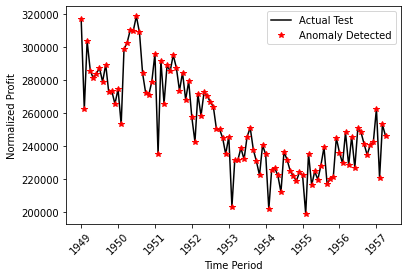

In [85]:
plt.plot(date, train.values.reshape(1,-1)[0], color = 'black')
plt.plot(anomaly_date, anomaly_value, 'r*')
plt.legend(['Actual Test', 'Anomaly Detected','Prediction Band'])
plt.xlabel('Time Period')
plt.xticks(rotation=45)
plt.ylabel('Normalized Profit')

In [45]:
from sklearn.cluster import DBSCAN

clustering1 = DBSCAN(eps=0.9, min_samples=2).fit(np.array(ts_dataframe['Temp']).reshape(-1,1))
labels = clustering1.labels_
labels

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1])

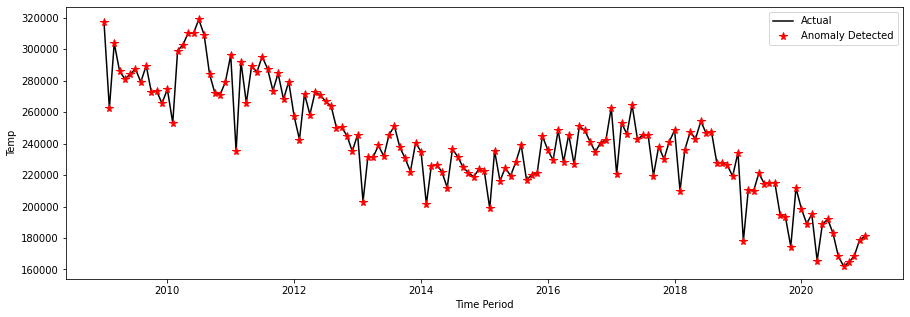

In [46]:
outlier_pos = np.where(labels == -1)[0]

x = []; y = [];
for pos in outlier_pos:
    x.append(np.array(ts_dataframe['Temp'])[pos])
    y.append(ts_dataframe['Temp'].index[pos])
    
plt.figure(figsize=(15,5))
plt.plot(ts_dataframe['Temp'].loc[ts_dataframe['Temp'].index], 'k-')
plt.plot(y,x,'r*', markersize=8)  
plt.legend(['Actual', 'Anomaly Detected'])
plt.xlabel('Time Period')
plt.ylabel('Temp')
plt.show()

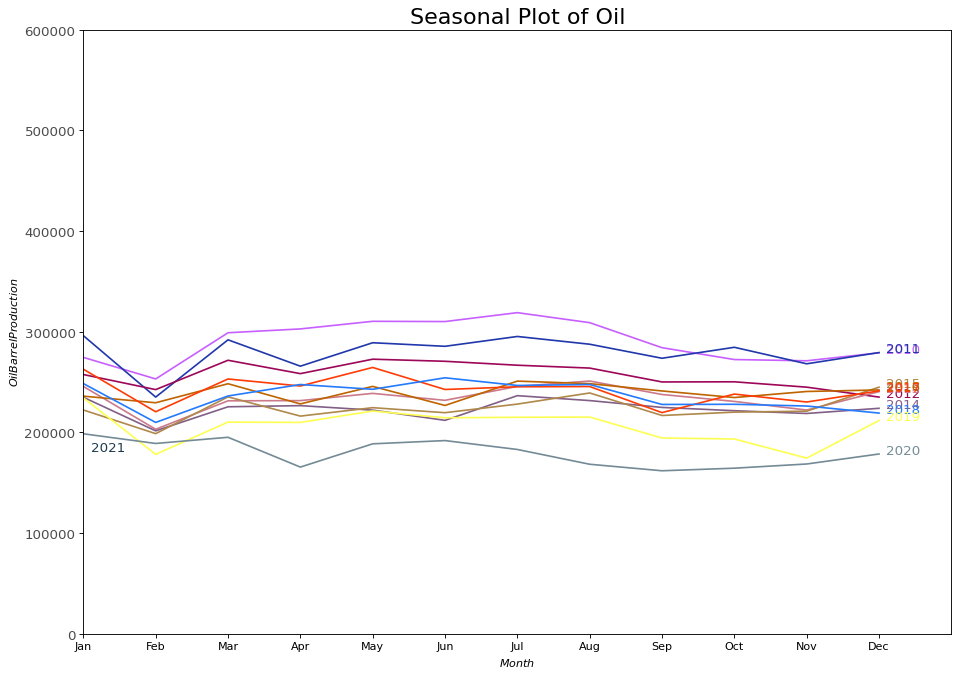

In [ ]:
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
years = df['year'].unique()
import matplotlib as mpl
# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(14,10), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'Barrels of Oil', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'Barrels of Oil'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(xlim=(0, 12), ylim=(0, 600000), ylabel='$Oil Barrel Production$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Oil", fontsize=20)
plt.show()

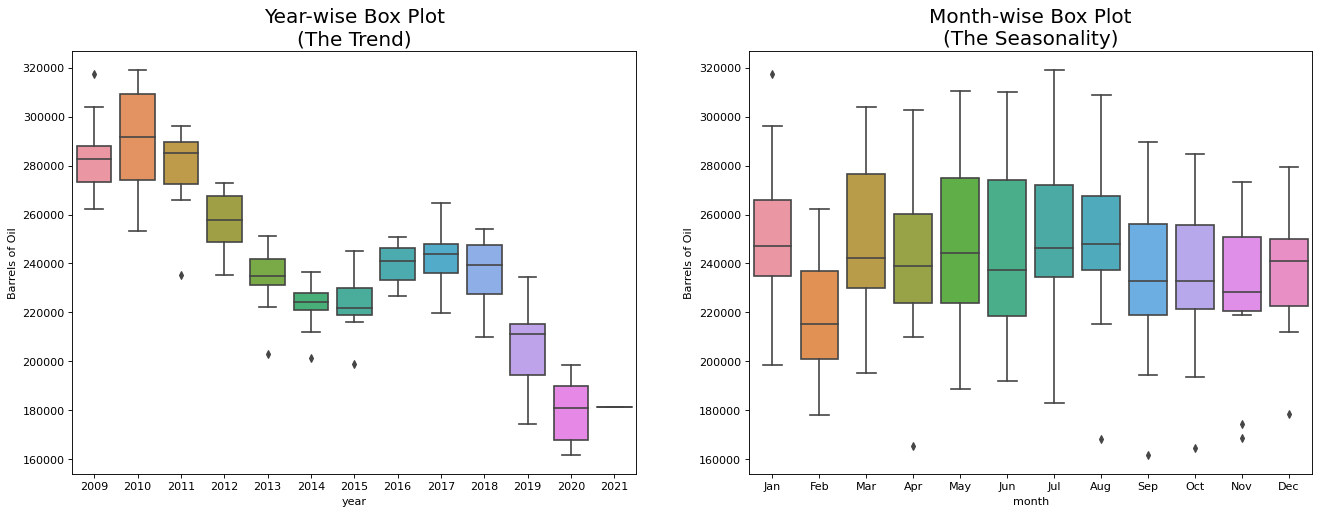

In [ ]:
years = df['year'].unique()
import seaborn as sns
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Barrels of Oil', data=df, ax=axes[0])
sns.boxplot(x='month', y='Barrels of Oil', data=df.loc[~df.year.isin([1991, 2021]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

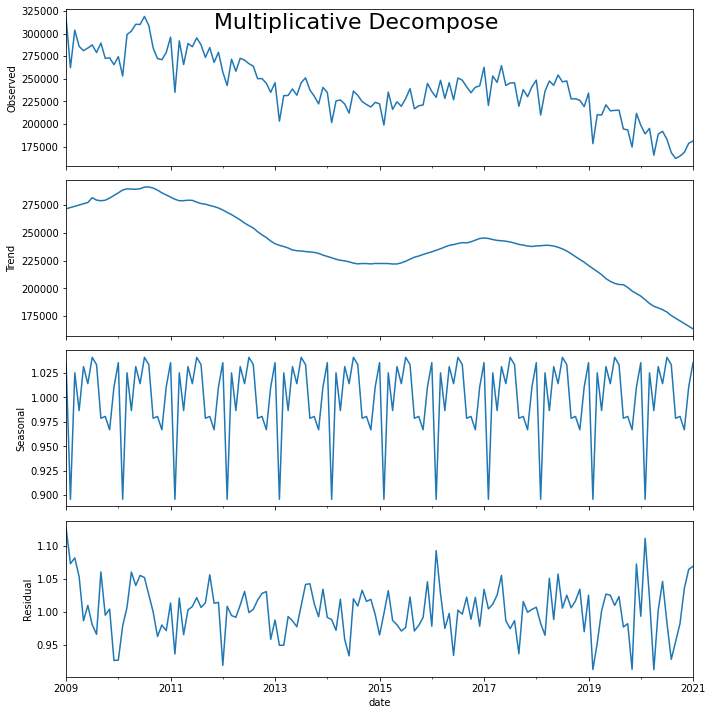

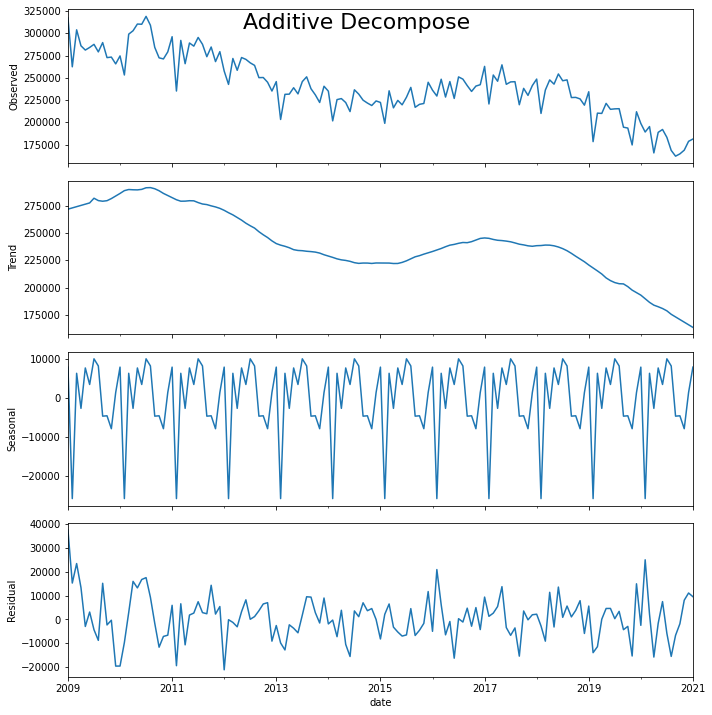

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['Barrels of Oil'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['Barrels of Oil'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()
pass;

In [ ]:
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed

,seas,trend,resid,actual_values
date,,,,
2009-01-01,1.035493,271765.528943,1.127442,317275
2009-02-01,0.895956,272904.252574,1.072917,262339
2009-03-01,1.025094,274042.976204,1.081792,303897
2009-04-01,0.986578,275181.699835,1.053209,285934
2009-05-01,1.031477,276320.423465,0.986418,281147
...,...,...,...,...
2020-09-01,0.978705,173229.024476,0.955090,161926
2020-10-01,0.980577,170837.156031,0.981943,164494
2020-11-01,0.966985,168445.287587,1.035430,168655


In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(df['Barrels of Oil'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 0.04326340691098666
p-value: 0.9619670163525729
Critial Values:
   1%, -3.481281802271349
Critial Values:
   5%, -2.883867891664528
Critial Values:
   10%, -2.5786771965503177


In [ ]:
# KPSS Test
result = kpss(df['Barrels of Oil'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 0.843092
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


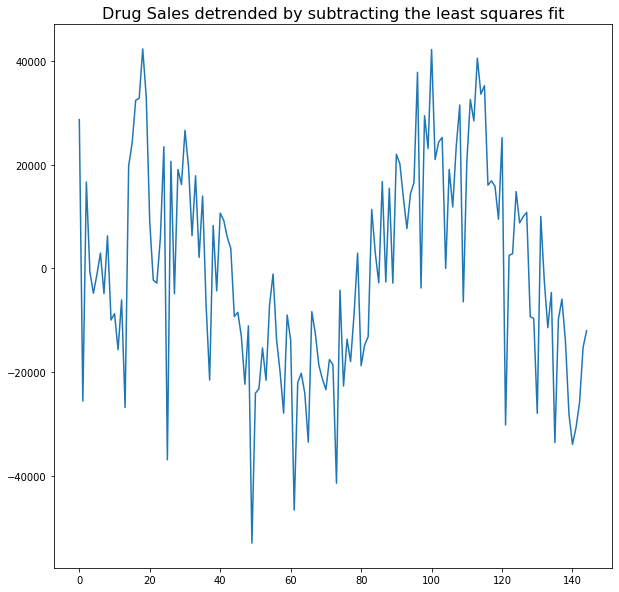

In [ ]:
from statsmodels.tsa.stattools import adfuller
df.drop(['year', 'month'], axis=1, inplace=True)
from scipy import signal
detrended = signal.detrend(df['Barrels of Oil'].values)
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the least squares fit', fontsize=16)
pass;

Text(0.5, 1.0, 'Drug Sales detrended by subtracting the trend component')

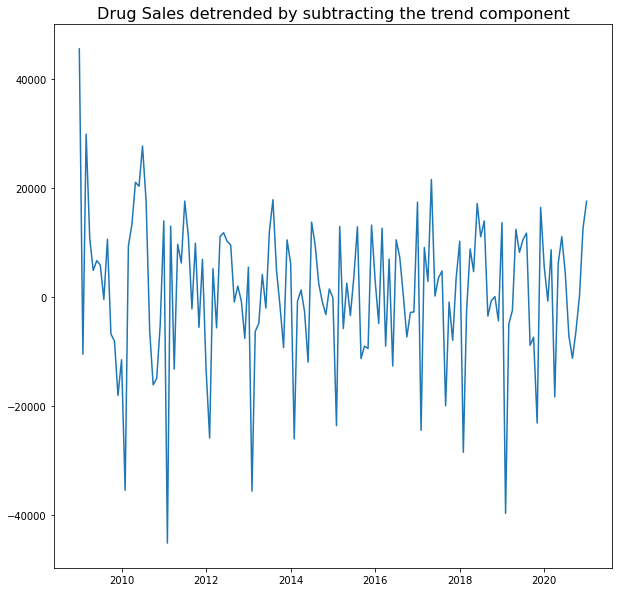

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(df['Barrels of Oil'], model='multiplicative', extrapolate_trend='freq')
detrended = df['Barrels of Oil'].values - result_mul.trend
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the trend component', fontsize=16)

[]

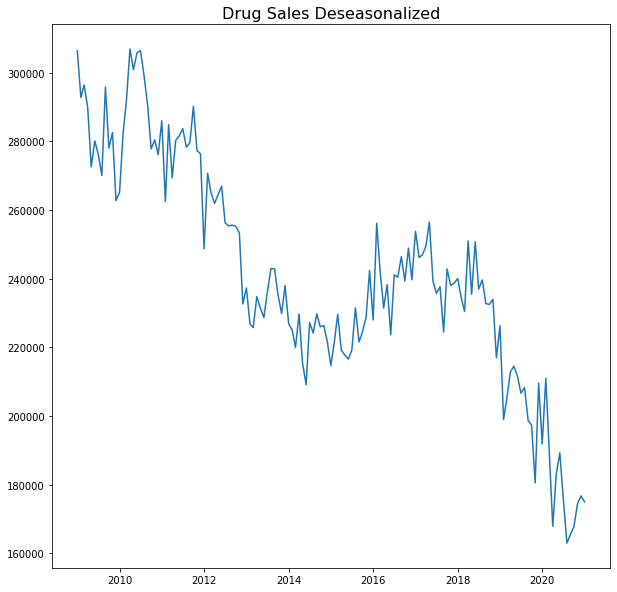

In [ ]:
# Time Series Decomposition
result_mul = seasonal_decompose(df['Barrels of Oil'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize
deseasonalized = df['Barrels of Oil'].values / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Drug Sales Deseasonalized', fontsize=16)
plt.plot()

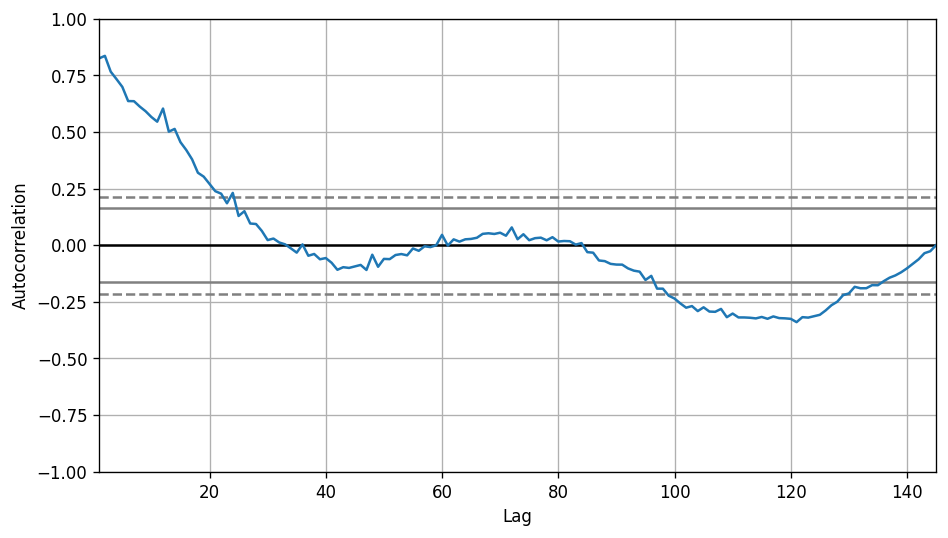

In [ ]:
from pandas.plotting import autocorrelation_plot

plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df['Barrels of Oil'].tolist())

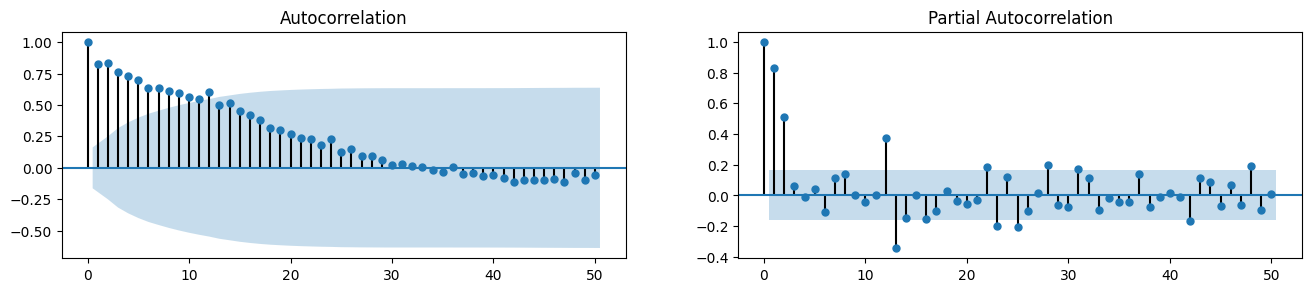

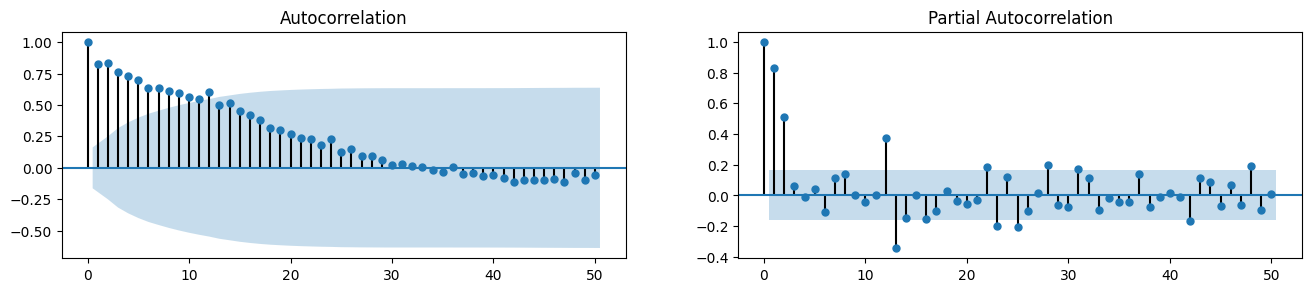

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['Barrels of Oil'].tolist(), lags=50, ax=axes[0])
plot_pacf(df['Barrels of Oil'].tolist(), lags=50, ax=axes[1])

In [ ]:
deseasonalized

date
2009-01-01    306399.804142
2009-02-01    292803.597584
2009-03-01    296457.580442
2009-04-01    289823.964562
2009-05-01    272567.507009
                  ...      
2020-09-01    165449.237427
2020-10-01    167752.283662
2020-11-01    174413.250431
2020-12-01    176709.358133
2021-01-01    174986.132885
Name: Barrels of Oil, Length: 145, dtype: float64

In [ ]:
detrended

date
2009-01-01    45509.471057
2009-02-01   -10565.252574
2009-03-01    29854.023796
2009-04-01    10752.300165
2009-05-01     4826.576535
                  ...     
2020-09-01   -11303.024476
2020-10-01    -6343.156031
2020-11-01      209.712413
2020-12-01    12543.580857
2021-01-01    17535.449301
Name: Barrels of Oil, Length: 145, dtype: float64

In [ ]:
df

,Barrels of Oil
date,
2009-01-01,317275
2009-02-01,262339
2009-03-01,303897
2009-04-01,285934
2009-05-01,281147
...,...
2020-09-01,161926
2020-10-01,164494
2020-11-01,168655


In [ ]:
df['Case'] = df['Barrels of Oil']
del df['Barrels of Oil']
df

,Case
date,
2009-01-01,317275
2009-02-01,262339
2009-03-01,303897
2009-04-01,285934
2009-05-01,281147
...,...
2020-09-01,161926
2020-10-01,164494
2020-11-01,168655


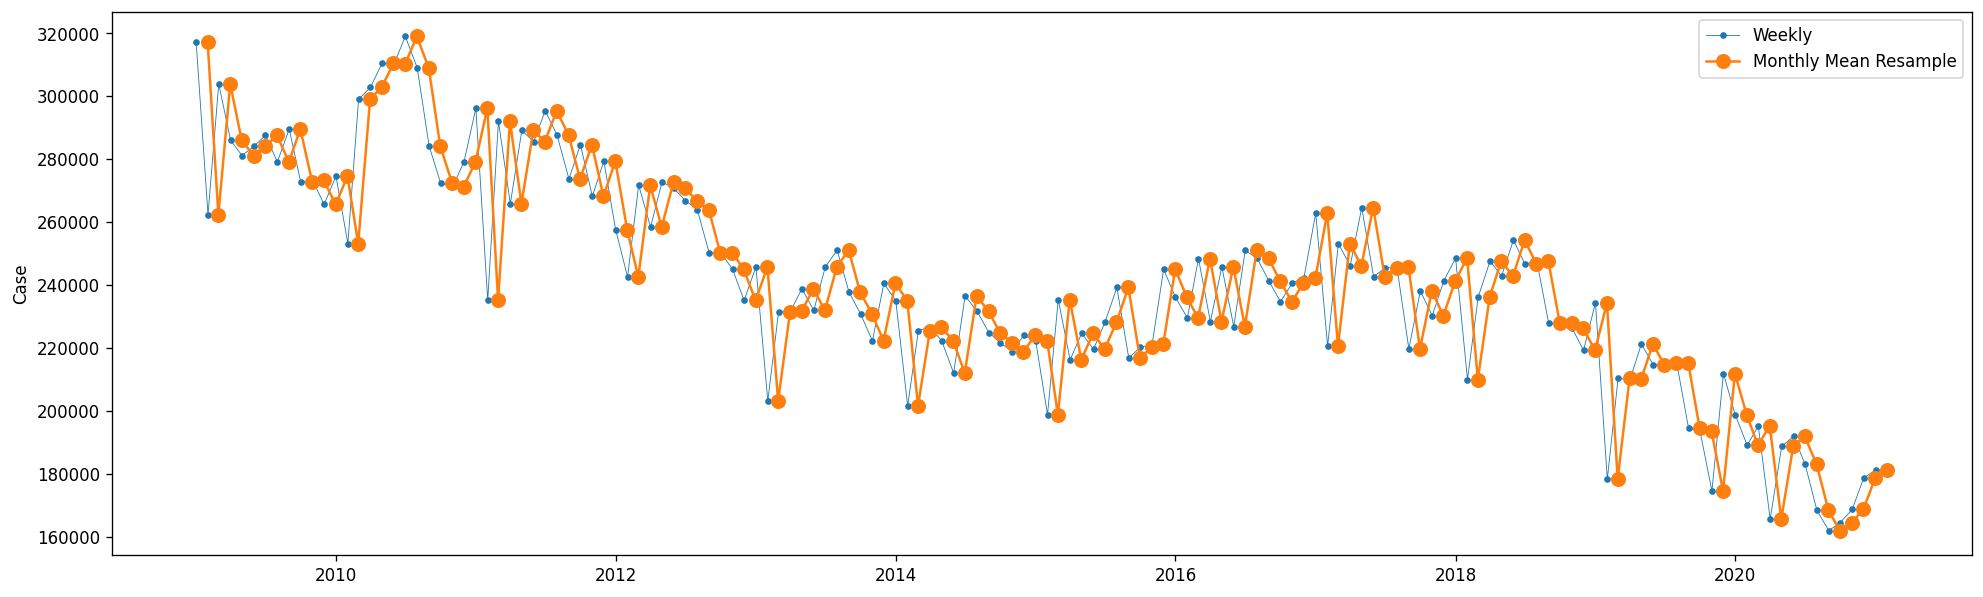

In [ ]:
import warnings
import matplotlib.pyplot as plt
y = df['Case']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Case')
ax.legend();
pass;

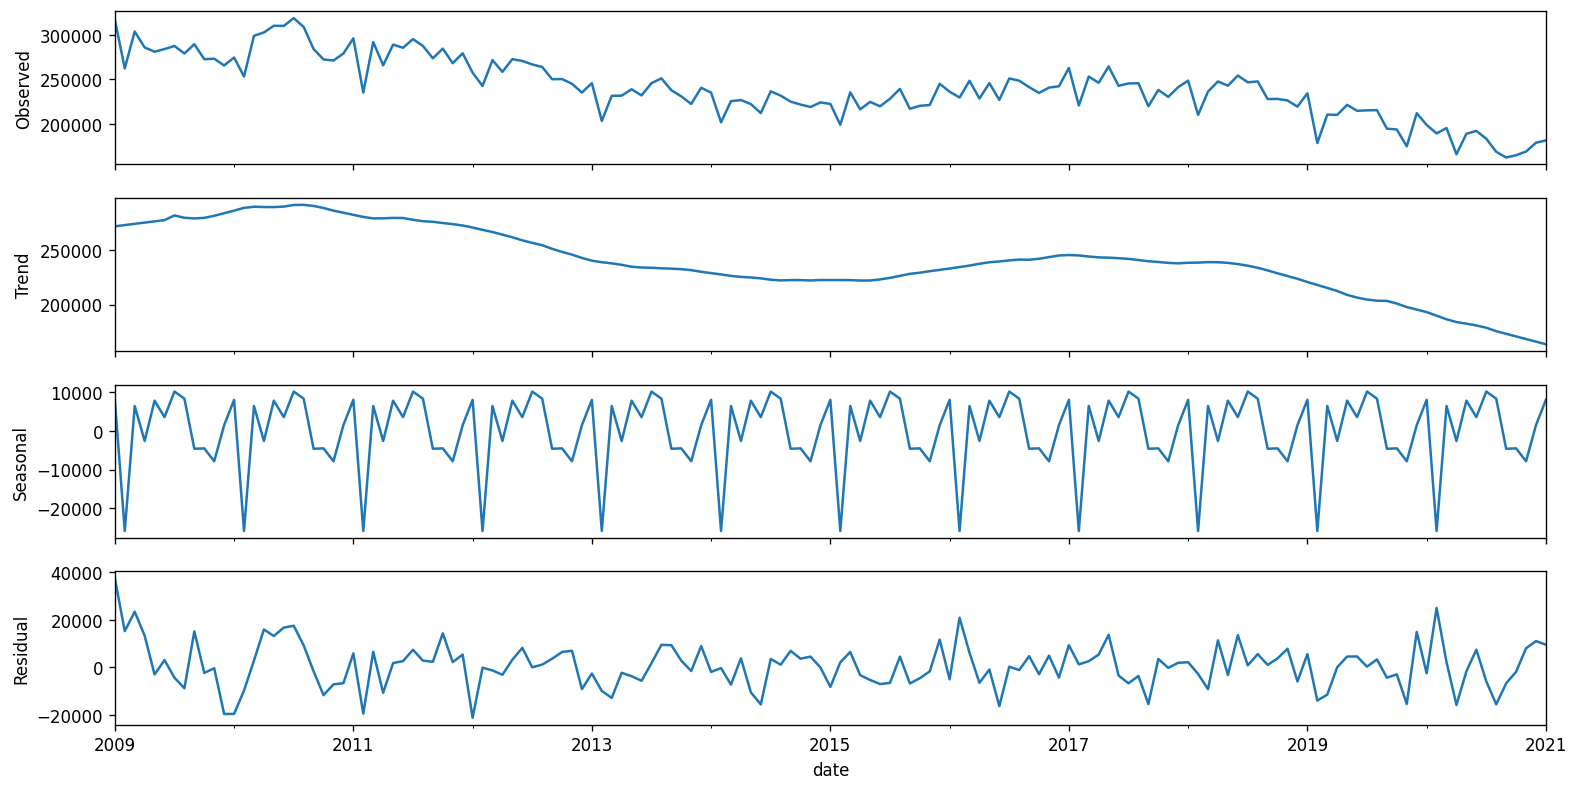

In [ ]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()
    pass;

seasonal_decompose(y)

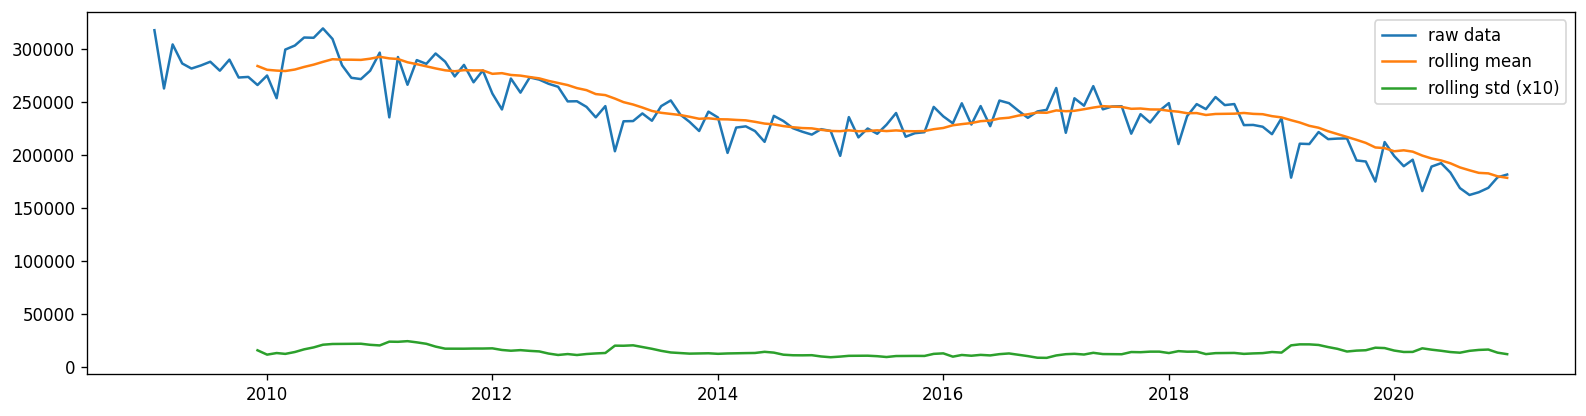

In [ ]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    pass;

pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')
pass;

In [ ]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [ ]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = 0.043
P-value = 0.962
Critical values :
	1%: -3.481281802271349 - The data is not stationary with 99% confidence
	5%: -2.883867891664528 - The data is not stationary with 95% confidence
	10%: -2.5786771965503177 - The data is not stationary with 90% confidence


 > Is the de-trended data stationary ?
Test statistic = -1.827
P-value = 0.367
Critical values :
	1%: -3.486055829282407 - The data is not stationary with 99% confidence
	5%: -2.8859430324074076 - The data is not stationary with 95% confidence
	10%: -2.5797850694444446 - The data is not stationary with 90% confidence


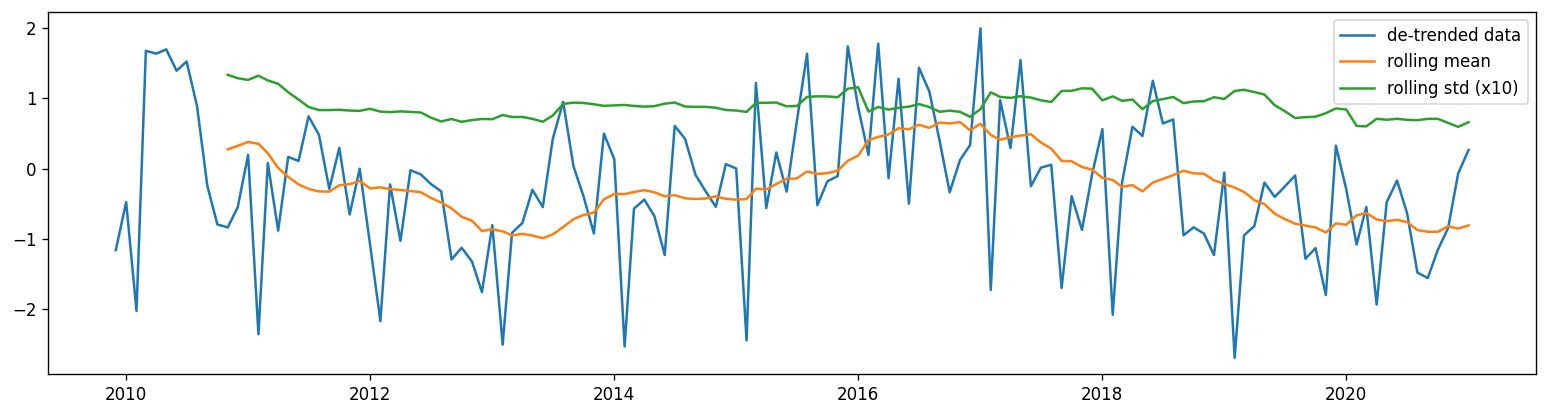

In [ ]:
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

 > Is the 12 lag differenced data stationary ?
Test statistic = -1.232
P-value = 0.660
Critical values :
	1%: -3.4865346059036564 - The data is not stationary with 99% confidence
	5%: -2.8861509858476264 - The data is not stationary with 95% confidence
	10%: -2.579896092790057 - The data is not stationary with 90% confidence


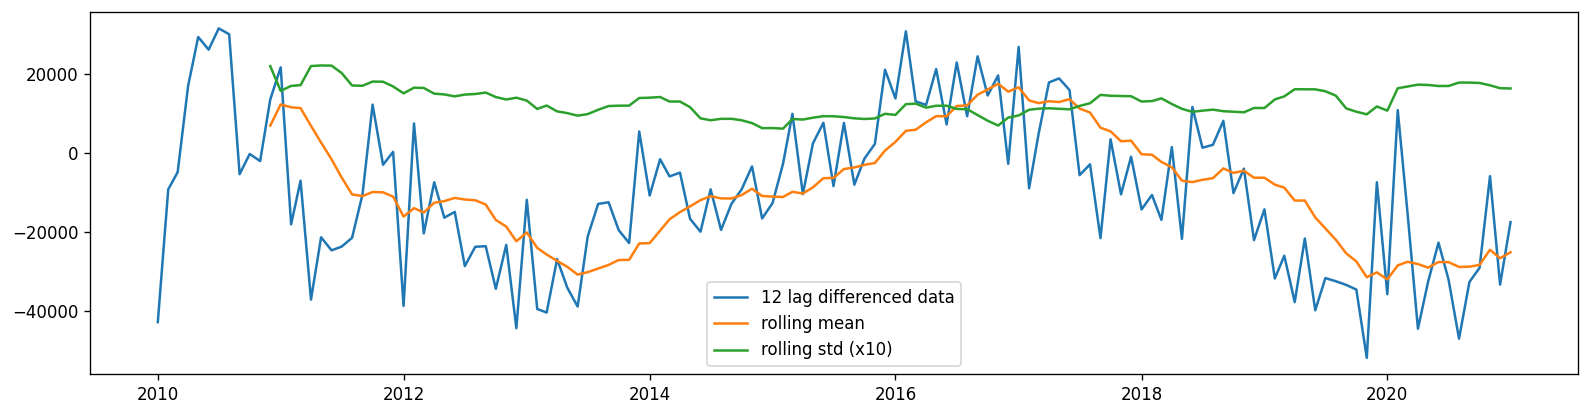

In [ ]:
# Differencing
y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -4.252
P-value = 0.001
Critical values :
	1%: -3.486055829282407 - The data is  stationary with 99% confidence
	5%: -2.8859430324074076 - The data is  stationary with 95% confidence
	10%: -2.5797850694444446 - The data is  stationary with 90% confidence


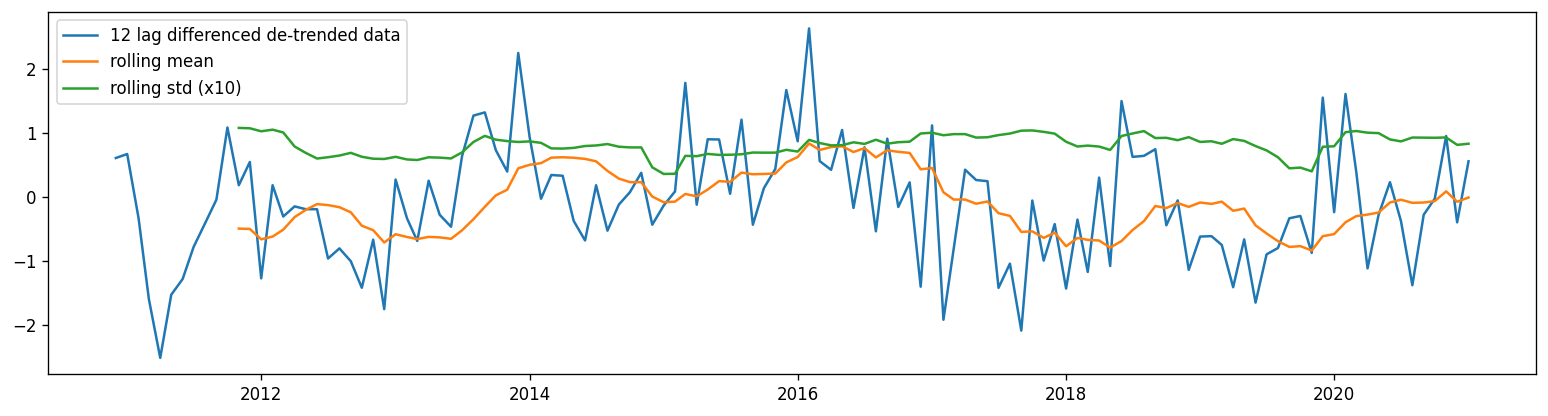

In [ ]:
y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

In [ ]:
y_to_train = y_12lag_detrend[:'2018-01-31'] # dataset to train
y_to_val = y_12lag_detrend['2018-02-01':] # last X months for test  
predict_date = len(y_12lag_detrend) - len(y_to_train) # the number of data points for the test set
print('Total number of data points in the test set is: ',predict_date)

Total number of data points in the test set is:  36


In [ ]:
len(y) == len(y_to_val) + len(y_to_train)

True

In [ ]:
ts = y
ts

date
2009-01-01    317275
2009-02-01    262339
2009-03-01    303897
2009-04-01    285934
2009-05-01    281147
               ...  
2020-09-01    161926
2020-10-01    164494
2020-11-01    168655
2020-12-01    178597
2021-01-01    181197
Name: Case, Length: 145, dtype: int64

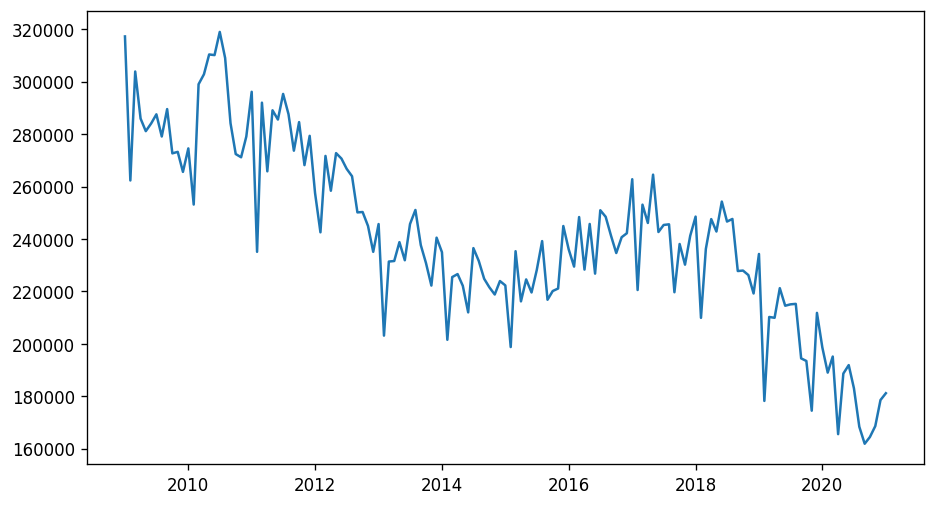

In [ ]:
plt.plot(ts)

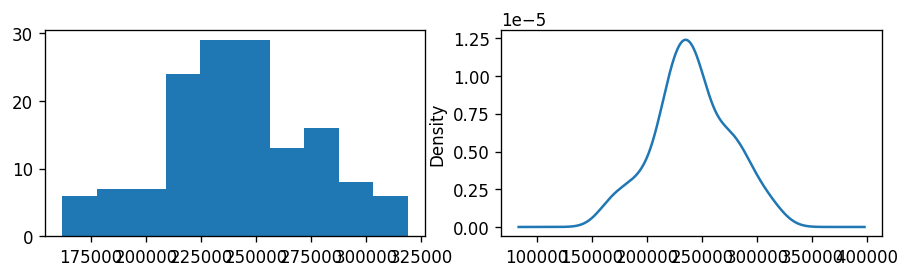

In [ ]:
plt.subplot(221)
plt.hist(ts)
plt.subplot(222)
ts.plot(kind = 'kde')
pass;

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determining rolling statistics
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()
    
    #plotting rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    st = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling  Mean & Standard Deviation')
    plt.show()
    
    #Dickey_Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

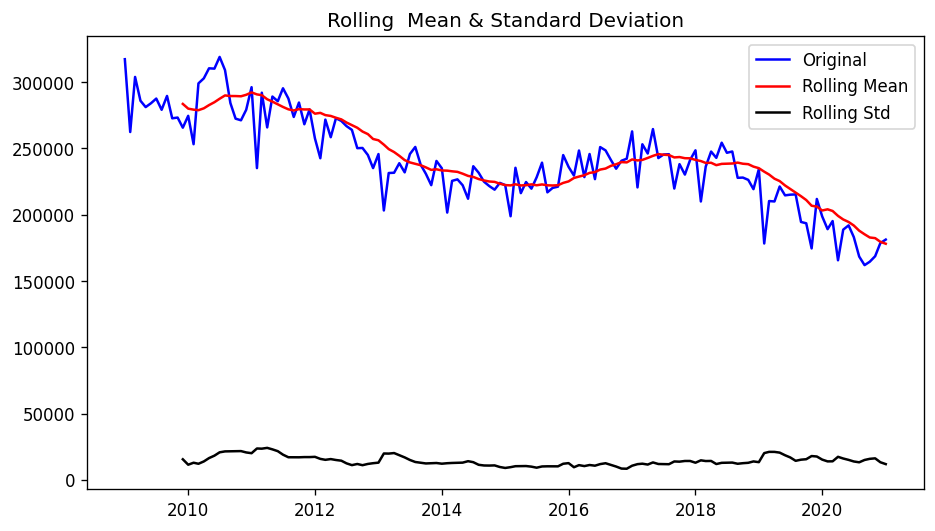

Results of Dickey-Fuller Test:
Test Statistic                  0.04326341
p-value                         0.96196702
#Lags Used                     13.00000000
Number of Observations Used   131.00000000
Critical Value (1%)            -3.48128180
Critical Value (5%)            -2.88386789
Critical Value (10%)           -2.57867720
dtype: float64


In [ ]:
test_stationarity(ts)

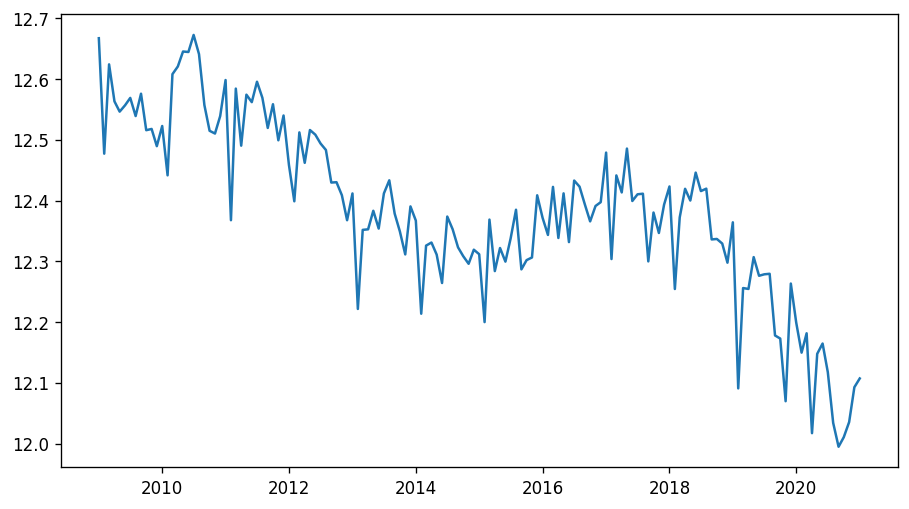

In [ ]:
ts_log = np.log(ts)
plt.plot(ts_log)

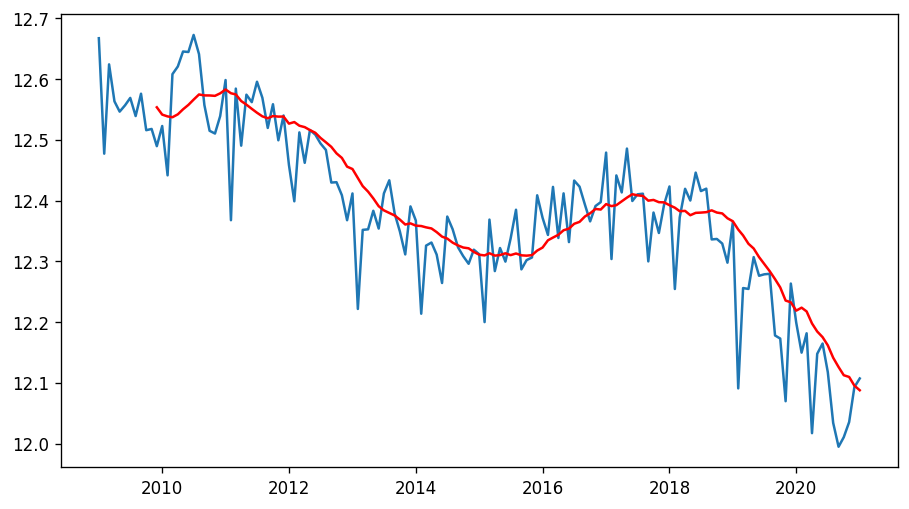

In [ ]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color = 'red')

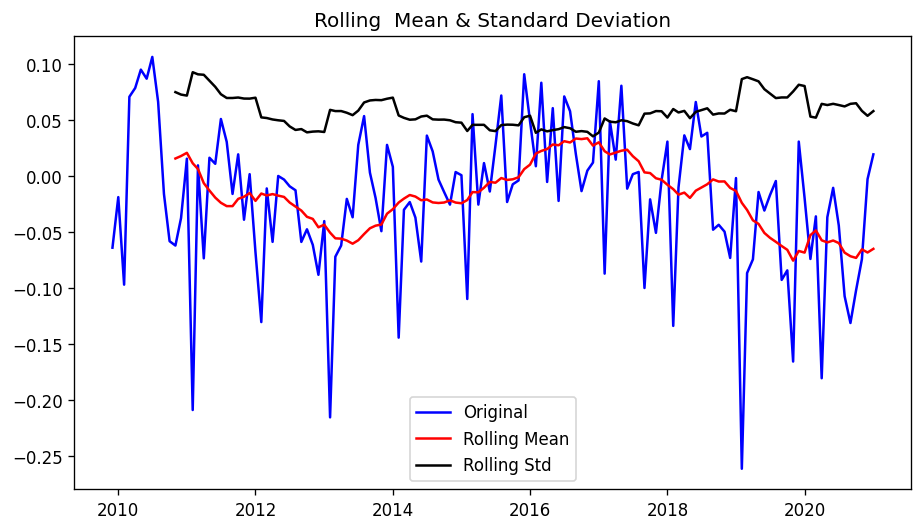

Results of Dickey-Fuller Test:
Test Statistic                 -1.58678328
p-value                         0.49022924
#Lags Used                     13.00000000
Number of Observations Used   120.00000000
Critical Value (1%)            -3.48605583
Critical Value (5%)            -2.88594303
Critical Value (10%)           -2.57978507
dtype: float64


In [ ]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(ts_log_moving_avg_diff)

In [ ]:
ts_log_moving_avg_diff

date
2009-12-01   -0.06396822
2010-01-01   -0.01876966
2010-02-01   -0.09701513
2010-03-01    0.07090118
2010-04-01    0.07875278
                 ...    
2020-09-01   -0.13127111
2020-10-01   -0.10200585
2020-11-01   -0.07417081
2020-12-01   -0.00267037
2021-01-01    0.01945135
Name: Case, Length: 134, dtype: float64

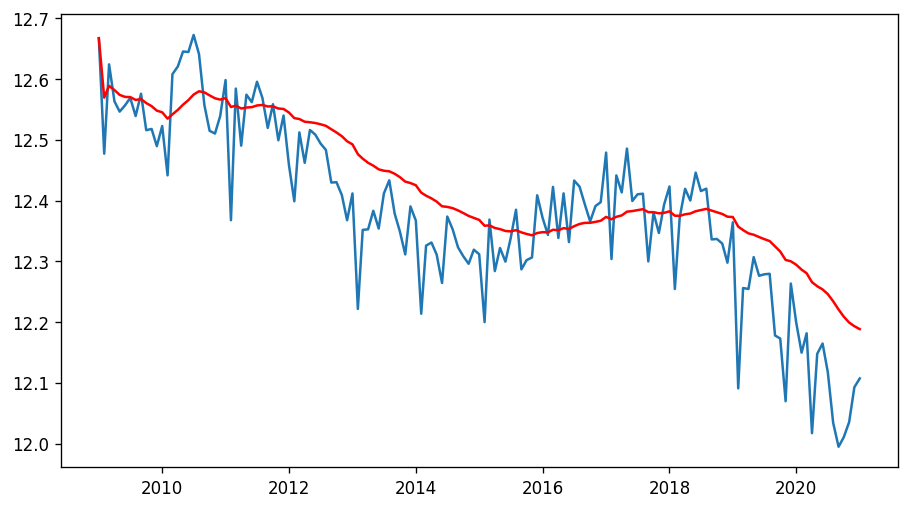

In [ ]:
exp_weighted_avg = ts_log.ewm(halflife = 12).mean()
plt.plot(ts_log)
plt.plot(exp_weighted_avg, color = 'red')

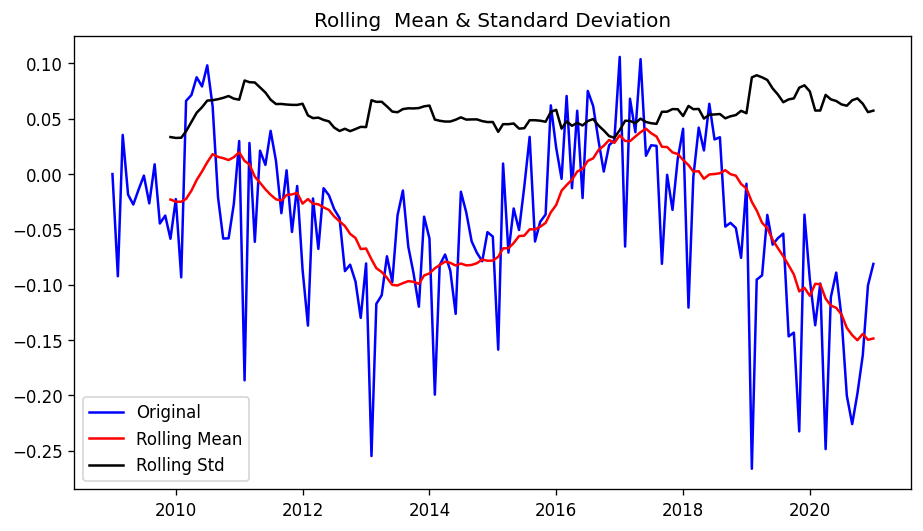

Results of Dickey-Fuller Test:
Test Statistic                 -1.08457912
p-value                         0.72118223
#Lags Used                     13.00000000
Number of Observations Used   131.00000000
Critical Value (1%)            -3.48128180
Critical Value (5%)            -2.88386789
Critical Value (10%)           -2.57867720
dtype: float64


In [ ]:
ts_log_ema_diff = ts_log - exp_weighted_avg
test_stationarity(ts_log_ema_diff)

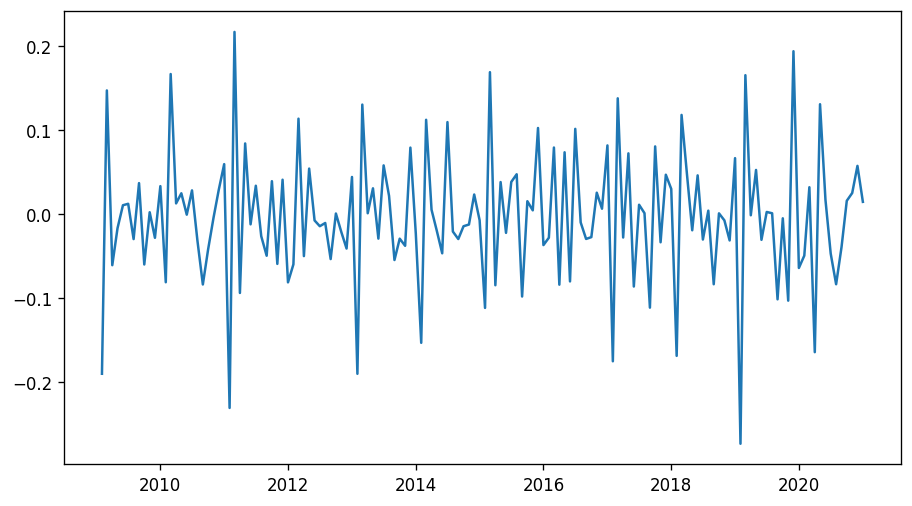

In [ ]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

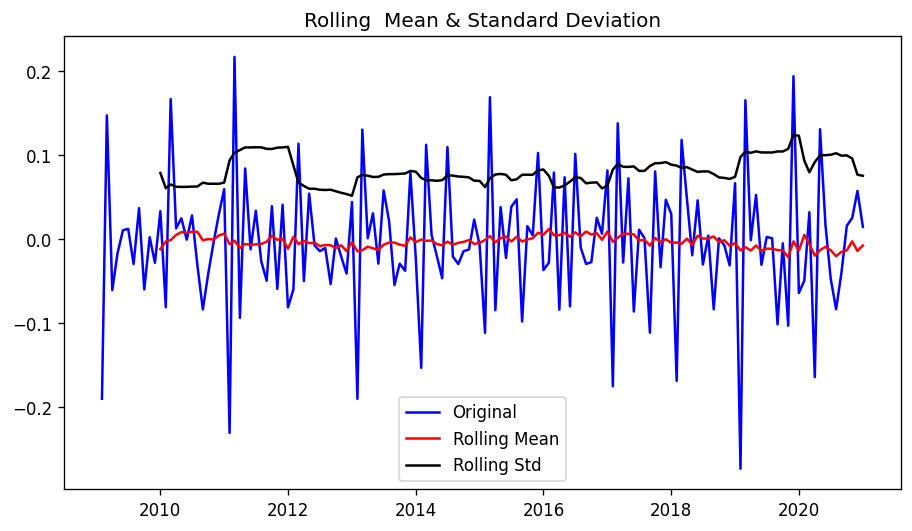

Results of Dickey-Fuller Test:
Test Statistic                 -2.98211051
p-value                         0.03659916
#Lags Used                     12.00000000
Number of Observations Used   131.00000000
Critical Value (1%)            -3.48128180
Critical Value (5%)            -2.88386789
Critical Value (10%)           -2.57867720
dtype: float64


In [ ]:
ts_log_diff.dropna(inplace = True)
test_stationarity(ts_log_diff)

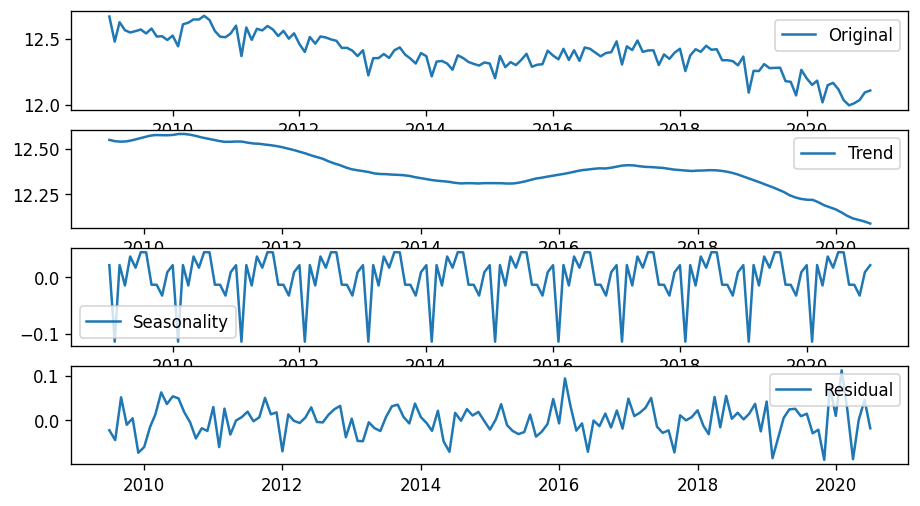

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')
pass;

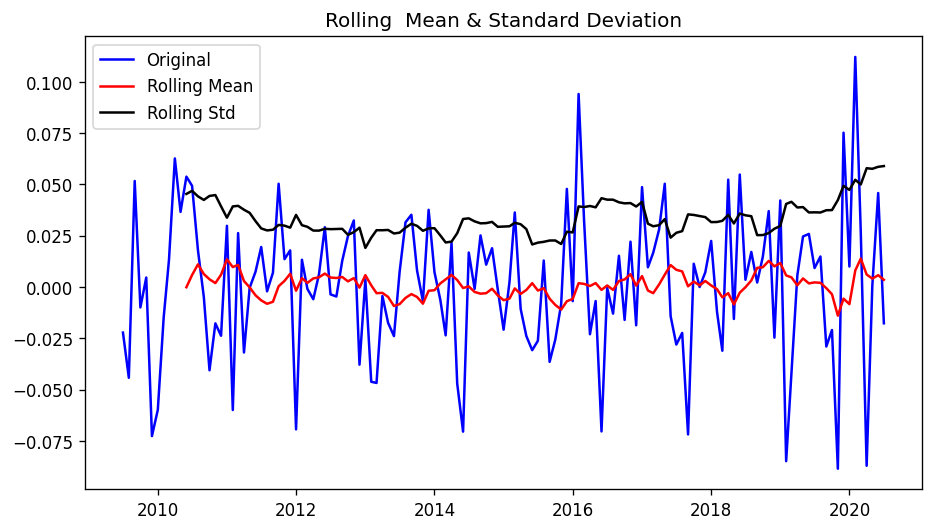

Results of Dickey-Fuller Test:
Test Statistic                 -6.17551405
p-value                         0.00000007
#Lags Used                     11.00000000
Number of Observations Used   121.00000000
Critical Value (1%)            -3.48558515
Critical Value (5%)            -2.88573857
Critical Value (10%)           -2.57967591
dtype: float64


In [ ]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace = True)
test_stationarity(ts_log_decompose)

In [ ]:
ts_log_decompose

date
2009-07-01   -0.02218808
2009-08-01   -0.04423024
2009-09-01    0.05171527
2009-10-01   -0.00992897
2009-11-01    0.00463755
                 ...    
2020-03-01    0.02693545
2020-04-01   -0.08711204
2020-05-01    0.00063595
2020-06-01    0.04585208
2020-07-01   -0.01766497
Name: Case, Length: 133, dtype: float64

In [ ]:
y_to_train = ts_log_decompose[:'2018-01-31'] # dataset to train
y_to_val = ts_log_decompose['2018-02-01':] # last X months for test  
predict_date = len(y) - len(y_to_train) # the number of data points for the test set
print('Total number of data points in the test set is: ',predict_date)

Total number of data points in the test set is:  42


**ATTENTION: YOU CAN USE THE PREVIOUS NOTEBOOK JUST DROP THE NaN**

In [ ]:
y_to_train

date
2009-07-01   -0.02218808
2009-08-01   -0.04423024
2009-09-01    0.05171527
2009-10-01   -0.00992897
2009-11-01    0.00463755
                 ...    
2017-09-01   -0.07184739
2017-10-01    0.01136232
2017-11-01    0.00002404
2017-12-01    0.00720404
2018-01-01    0.02248603
Name: Case, Length: 103, dtype: float64

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is 0.05
The Root Mean Squared Error of our forecasts with auto optimization is 0.04


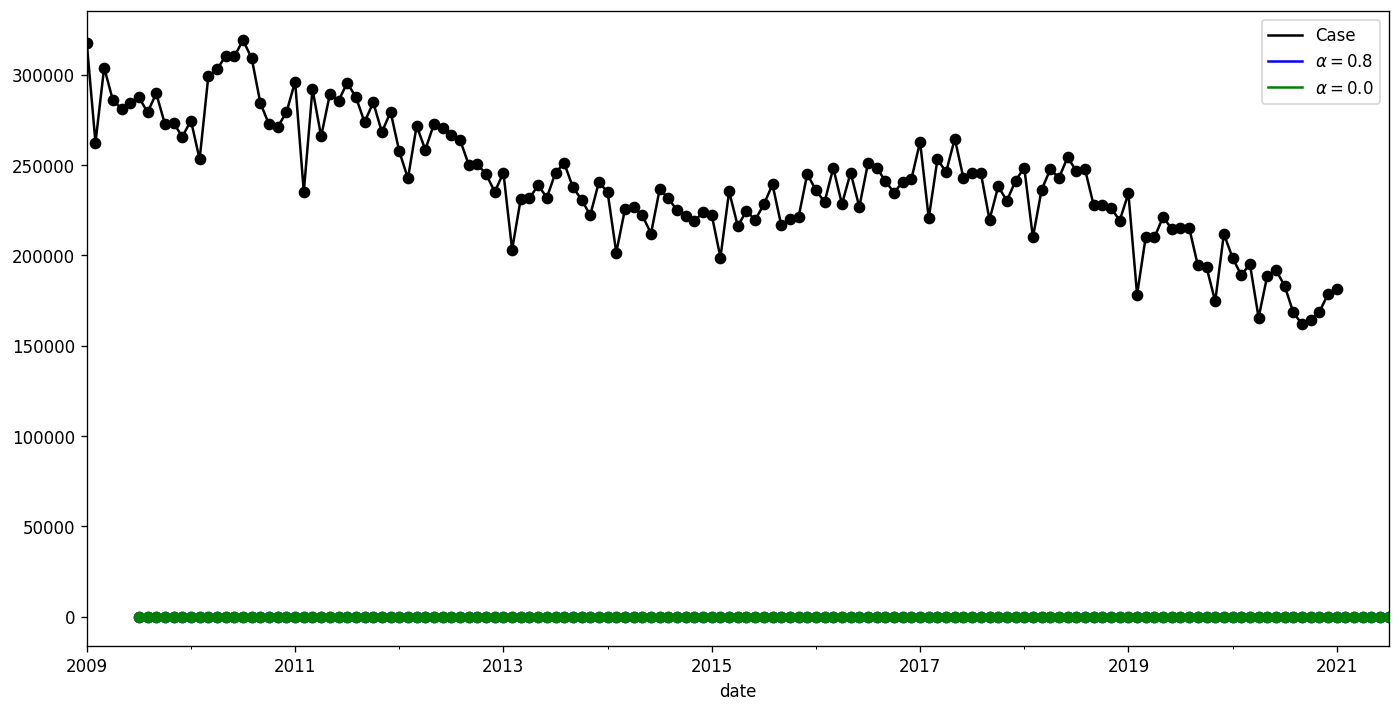

In [ ]:
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing 

def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()
    pass;

ses(y, y_to_train,y_to_val,0.8,predict_date)
pass;

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


The Root Mean Squared Error of Holts Linear trend 0.1
The Root Mean Squared Error of Holts Exponential trend 0.1


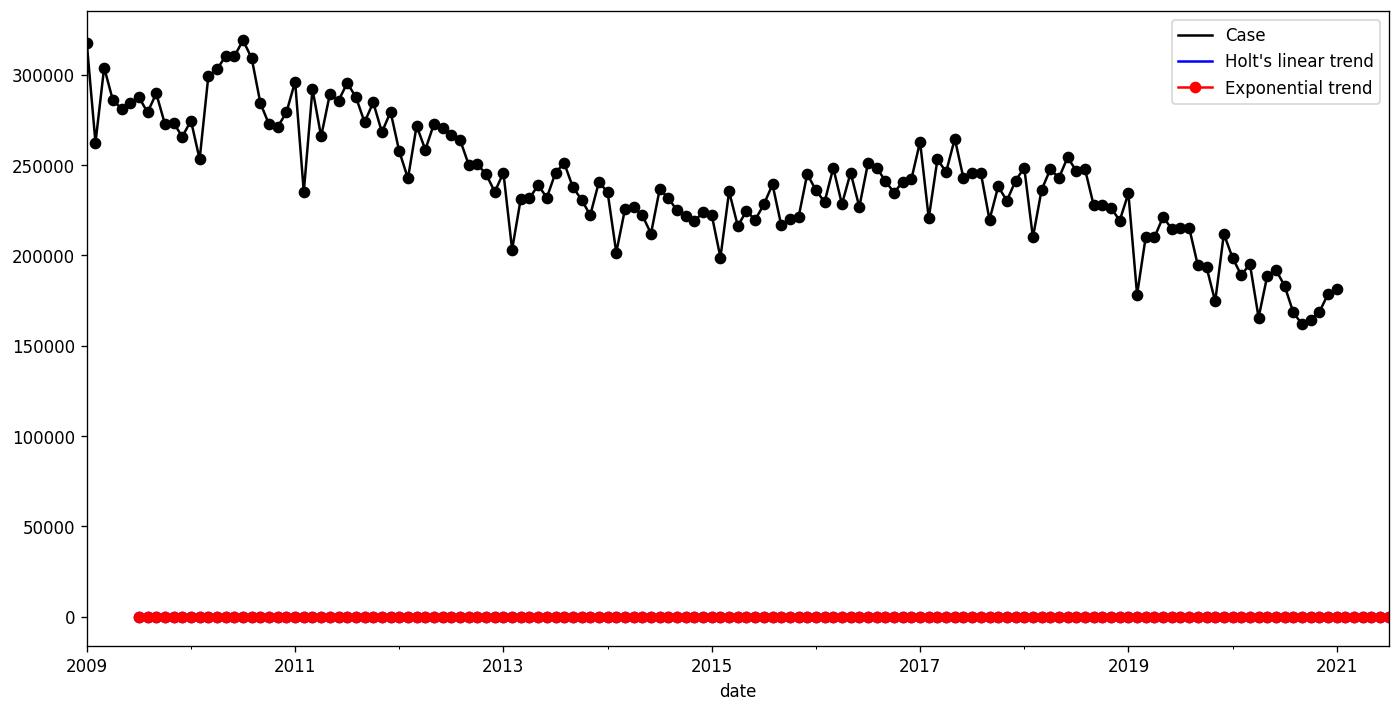

In [ ]:
from statsmodels.tsa.api import Holt

def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))

    """
    ATTENTION: I see the exponential option to be FALSE just for this fit2.

    The Original notebook had it set to TRUE.
    """

    fit2 = Holt(y_to_train, exponential=False).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    fit2.fittedvalues.plot(marker="o", color='red')
    fcast2.plot(color='red', marker="o", legend=True)

    plt.show()
    pass;

holt(y, y_to_train,y_to_val,0.6,0.2,predict_date)

In [ ]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [ ]:
sarima_grid_search(ts_log_decompose,52)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

The set of parameters with the minimum AIC is: SARIMA(0, 0, 0)x(0, 0, 0, 52) - AIC:-506.30509347273465


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0012      0.000      9.227      0.000       0.001       0.002


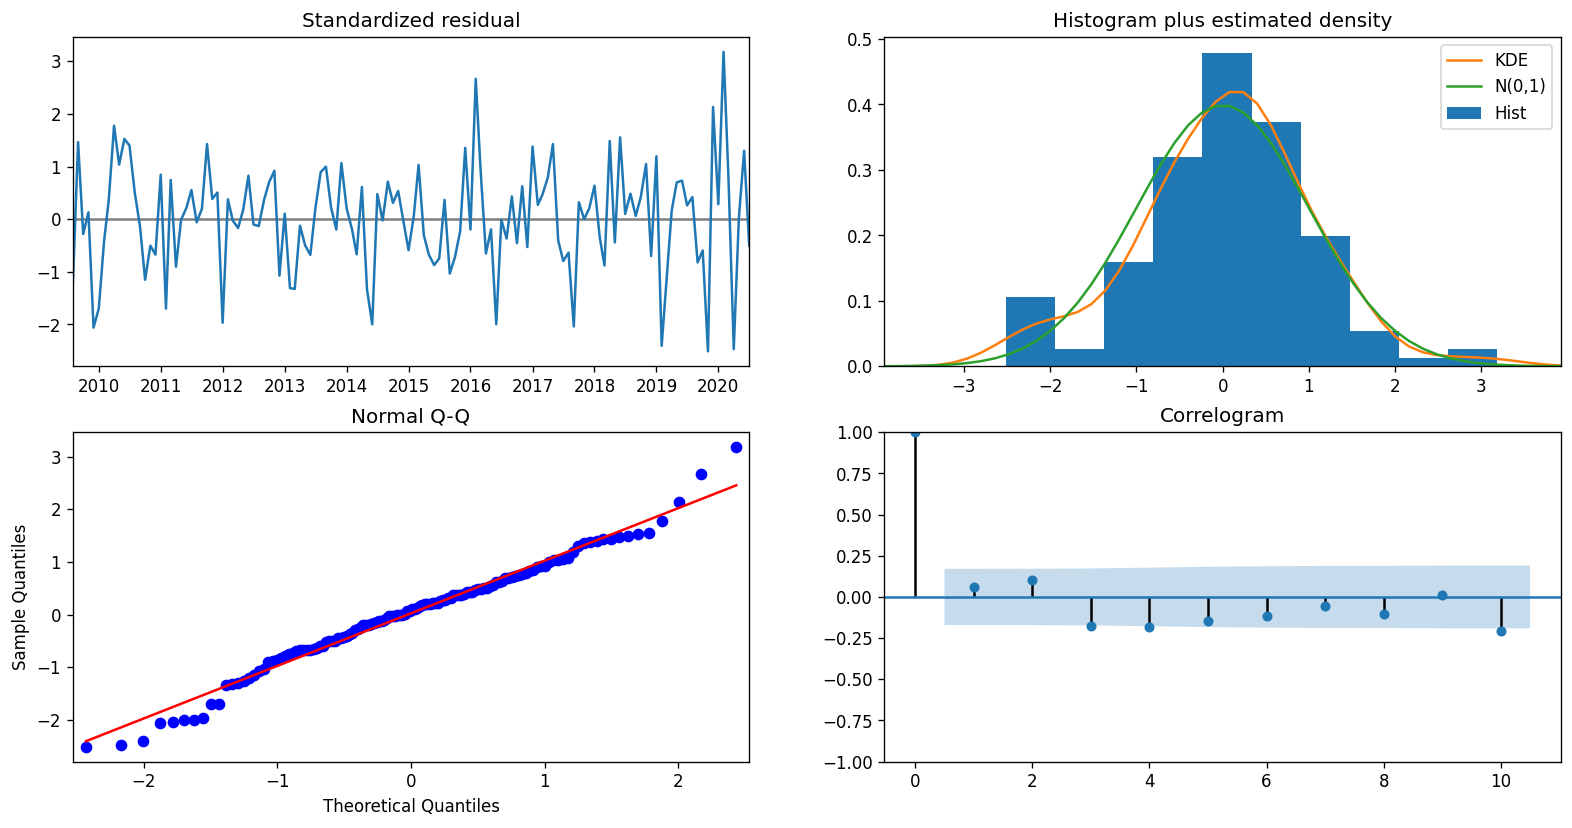

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = False 0.04


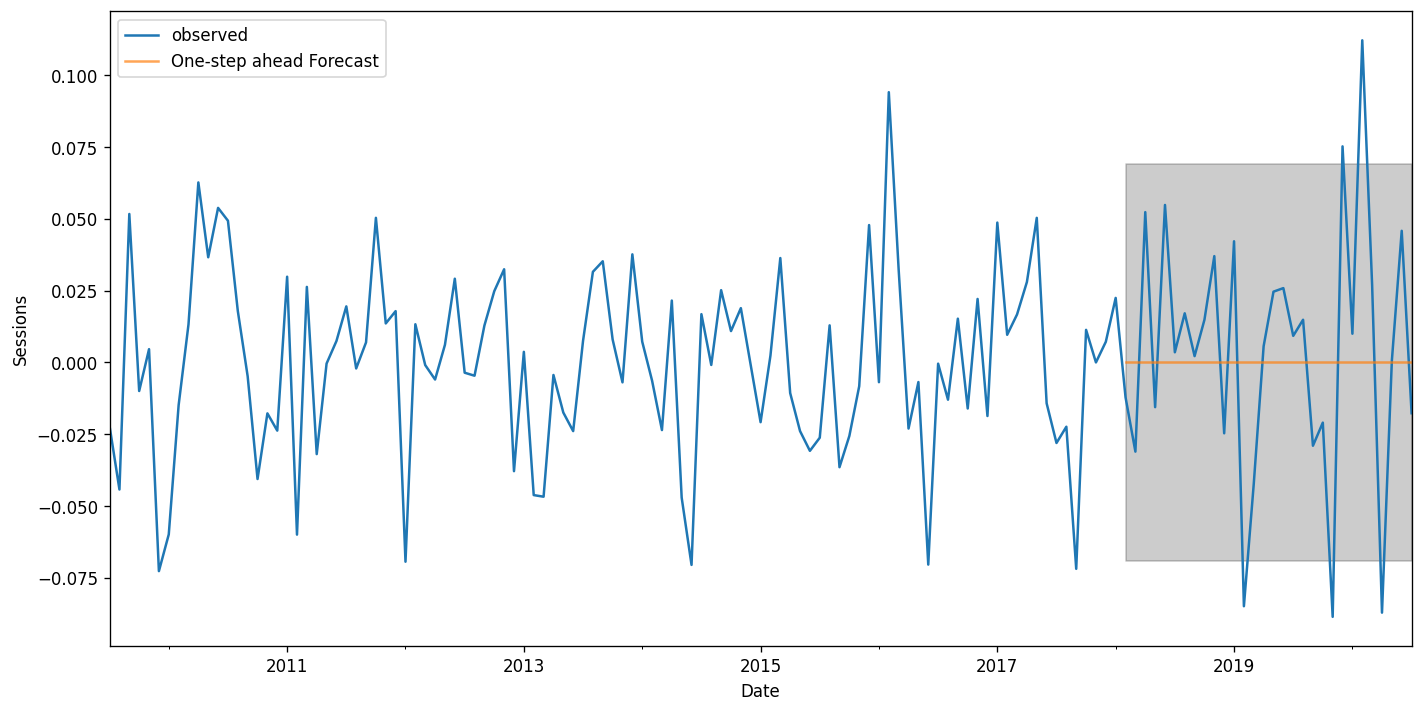

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = True 0.04


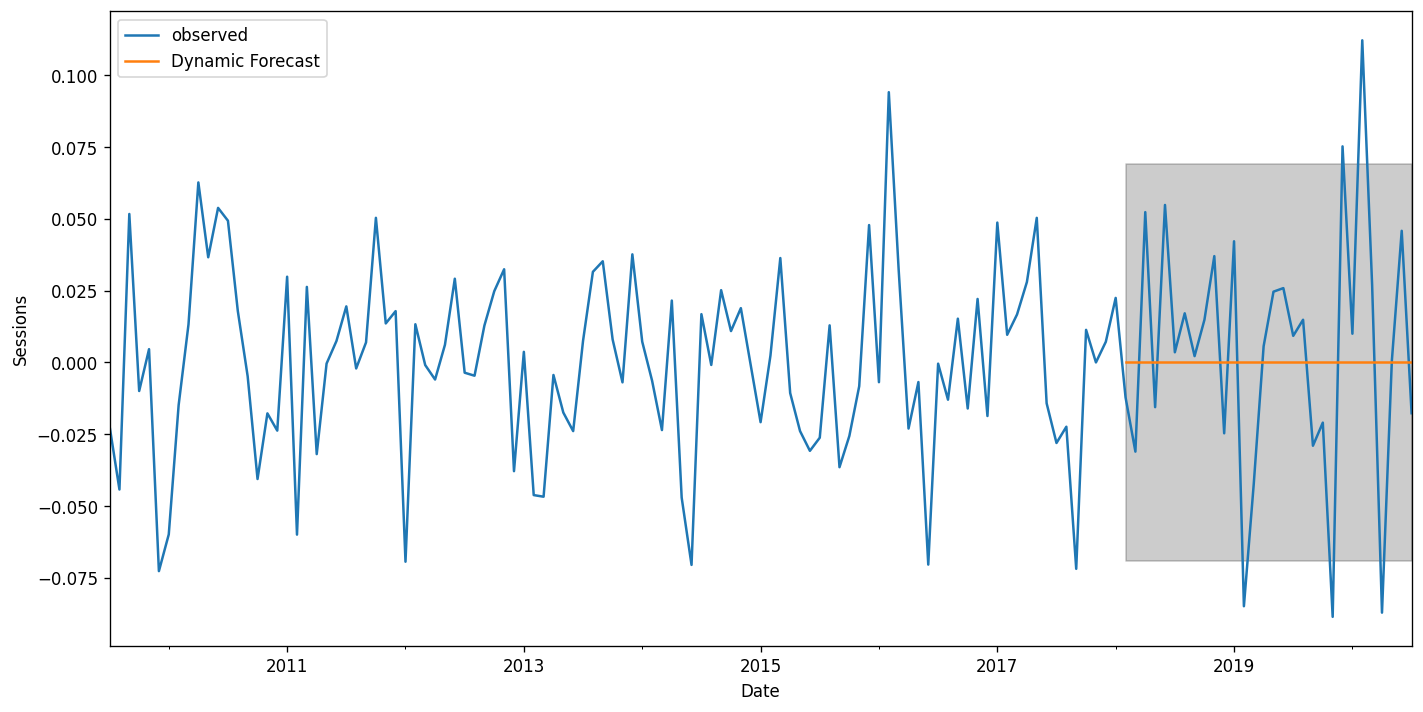

In [ ]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

model = sarima_eva(ts_log_decompose,(0, 0, 0),(0, 0, 0, 52),52,'2018-02-01',y_to_val)

In [ ]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

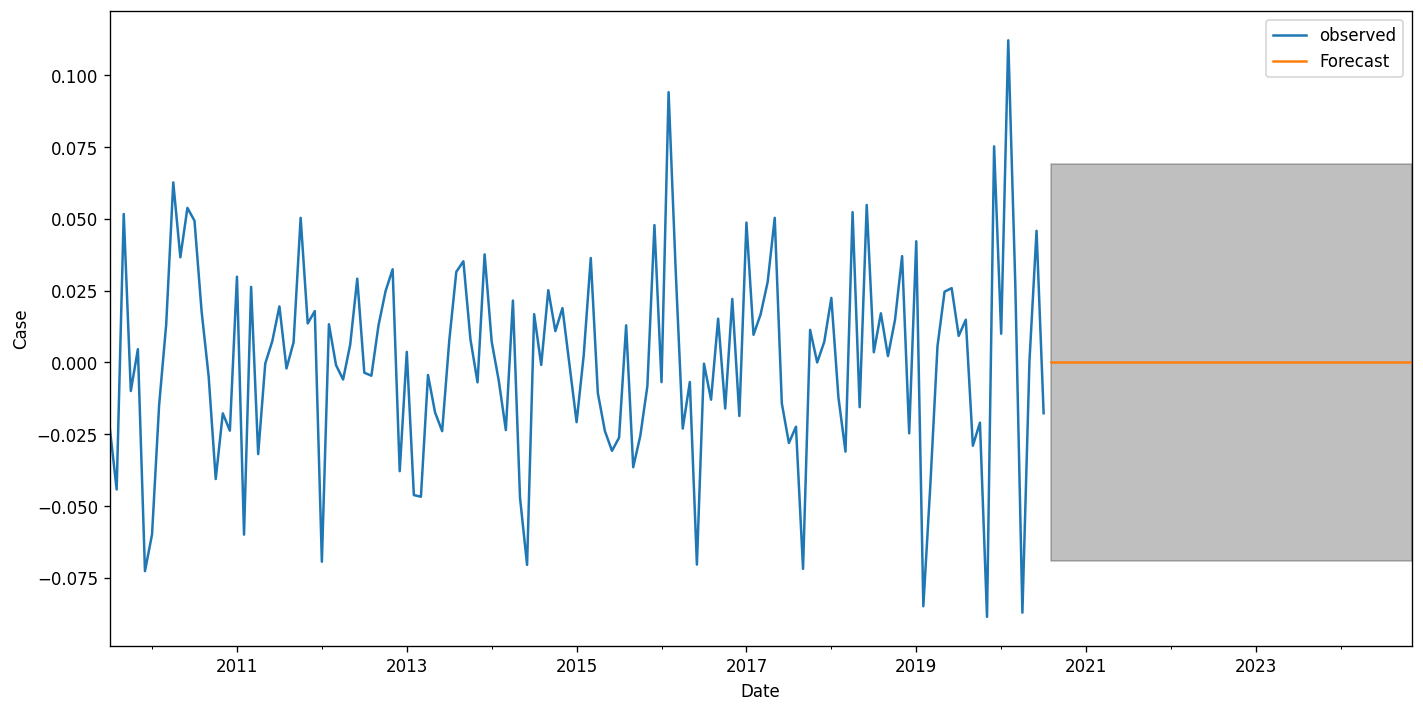

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2020-08-01,0.00000000,-0.06915403,0.06915403
1,2020-09-01,0.00000000,-0.06915403,0.06915403
2,2020-10-01,0.00000000,-0.06915403,0.06915403
3,2020-11-01,0.00000000,-0.06915403,0.06915403
4,2020-12-01,0.00000000,-0.06915403,0.06915403


In [ ]:
final_table = forecast(model,52,ts_log_decompose)
final_table.head()

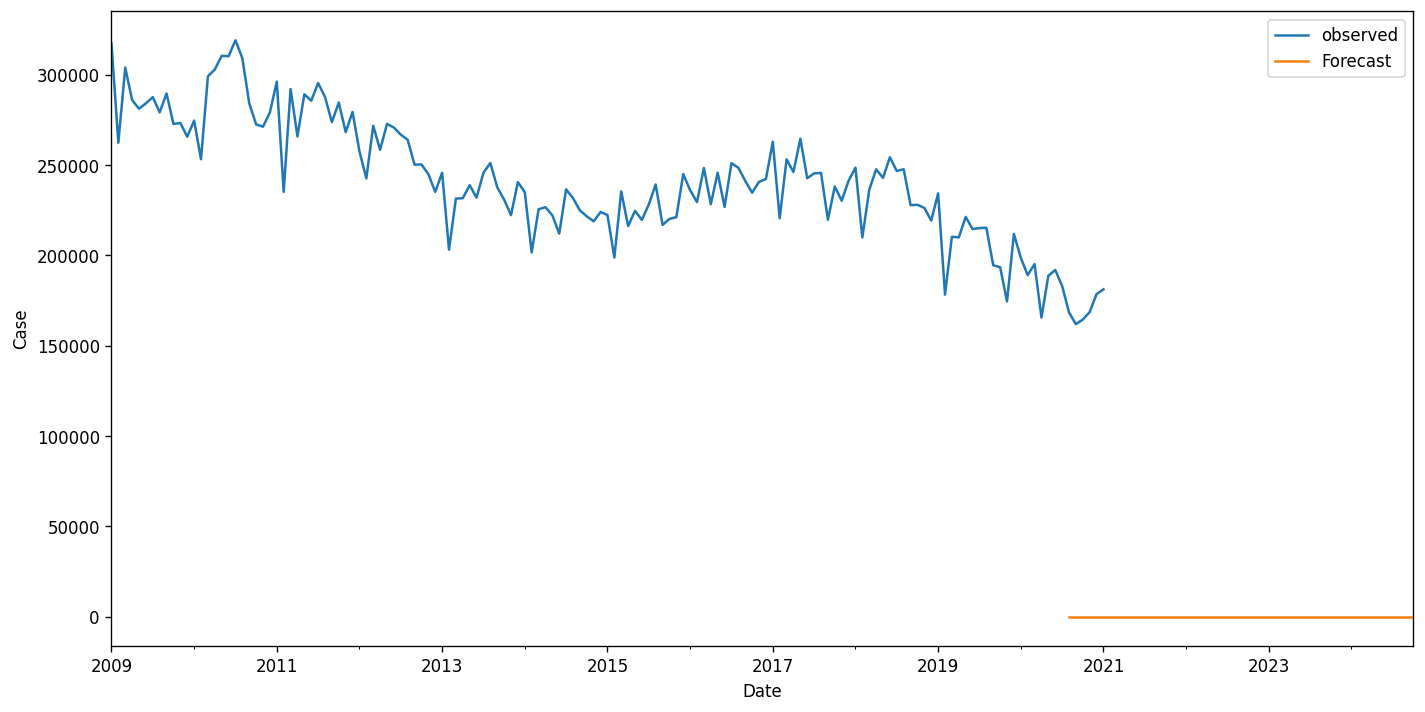

In [ ]:
pred_uc = model.get_forecast(steps=51)
ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(ts_log_decompose.name)

plt.legend()
plt.show()